# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [2]:
import pandas as pd
import spacy
from collections import Counter

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")


file_path = "tweets_csv"
df = pd.read_csv(file_path)

df["text"] = df["text"].astype(str)


def generate_ngrams(text, n):
    words = text.split()
    return [" ".join(words[i:i+n]) for i in range(len(words)-n+1)]

# (1) Count frequency of Bigrams (N=2) and Trigrams (N=3)
bigram_counts = Counter()
trigram_counts = Counter()

for tweet in df["text"]:
    bigram_counts.update(generate_ngrams(tweet, 2))
    trigram_counts.update(generate_ngrams(tweet, 3))

print("Top 10 Bigrams:", bigram_counts.most_common(10))
print("Top 10 Trigrams:", trigram_counts.most_common(10))

# (2) Calculate bigram probabilities P(w2 | w1) = count(w1 w2) / count(w1)
word_counts = Counter()
for tweet in df["text"]:
    word_counts.update(tweet.split())

bigram_probs = {bg: count / word_counts[bg.split()[0]] for bg, count in bigram_counts.items() if bg.split()[0] in word_counts}

print("\nBigram Probabilities (Top 10):")
for bigram, prob in list(bigram_probs.items())[:10]:
    print(f"{bigram}: {prob:.4f}")

# (3) Extract noun phrases and calculate relative probability per tweet
def extract_noun_phrases(text):
    doc = nlp(text)
    return [chunk.text.lower() for chunk in doc.noun_chunks]  # Convert to lowercase for consistency

# Extract all noun phrases from the dataset
noun_phrases = []
for tweet in df["text"]:
    noun_phrases.extend(extract_noun_phrases(tweet))

# Count the occurrences of each noun phrase
noun_phrase_counts = Counter(noun_phrases)
max_freq = max(noun_phrase_counts.values())  # Get the max frequency for normalization


def compute_relative_probability(text):
    np_list = extract_noun_phrases(text)
    return {np: noun_phrase_counts[np] / max_freq for np in np_list}

df["noun_phrase_probs"] = df["text"].apply(compute_relative_probability)

noun_phrase_df = pd.DataFrame(df["noun_phrase_probs"].tolist()).fillna(0)
noun_phrase_df.index = df.index  # Align index with original DataFrame


print("\nNoun Phrase Probability Table (First 5 Tweets):")
print(noun_phrase_df.head())

# Save results to CSV for further analysis
bigram_df = pd.DataFrame(bigram_counts.items(), columns=["Bigram", "Count"])
trigram_df = pd.DataFrame(trigram_counts.items(), columns=["Trigram", "Count"])
bigram_prob_df = pd.DataFrame(bigram_probs.items(), columns=["Bigram", "Probability"])

bigram_df.to_csv("bigram_counts.csv", index=False)
trigram_df.to_csv("trigram_counts.csv", index=False)
bigram_prob_df.to_csv("bigram_probabilities.csv", index=False)
noun_phrase_df.to_csv("noun_phrase_probabilities.csv", index=False)

print("\nAnalysis completed. Results saved as CSV files.")


Top 10 Bigrams: [('#AI #LLM', 14), ('#LLM #AI', 6), ('#NLP #LLM', 6), ('#LLM #GenAI', 6), ('🫵 https://t.co/gOsgK4BPyv', 5), ('#AIagent #AI', 5), ('#AI #ML', 5), ('#ML #NLP', 5), ('#AI #MachineLearning', 4), ('#GenAI #LLM', 3)]
Top 10 Trigrams: [('#AIagent #AI #ML', 5), ('#AI #ML #NLP', 5), ('#ML #NLP #LLM', 5), ('#NLP #LLM #GenAI', 5), ('https://t.co/lcFI4d7mhX #AI #LLM', 2), ('#AI #GenAI #LLM', 2), ('SGPT-3.0 #LLM #Grok3', 2), ('#LLM #Grok3 #SGPT', 2), ('Livebook 上で日本語テキスト埋め込みモデル Ruri', 2), ('#Qiita #MyElixirStatus #LLM', 2)]

Bigram Probabilities (Top 10):
Dobby: The: 0.5000
The best: 0.1250
best LLM: 1.0000
LLM personality,: 0.1111
personality, outperforming: 1.0000
outperforming SOTA: 1.0000
SOTA models.: 0.5000
models. Compare: 0.5000
Compare with: 1.0000
with Llama: 0.0556

Noun Phrase Probability Table (First 5 Tweets):
      dobby  the best llm personality  outperforming sota models     llama  \
0  0.076923                  0.038462                   0.038462  0.076923   
1  0.

## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [3]:
import pandas as pd
import numpy as np
import math


df = pd.read_csv("tweets_csv")

# Drop NaN values in 'text' column
df = df.dropna(subset=["text"])

def preprocess(text):
    return text.lower().split()

documents = df["text"].astype(str).tolist()  # Ensure all entries are strings
tokenized_docs = [preprocess(doc) for doc in documents]

# Step 1: Compute TF (Term Frequency)
tf = []
for doc in tokenized_docs:
    term_counts = {}
    total_terms = len(doc)
    for word in doc:
        term_counts[word] = term_counts.get(word, 0) + 1
    tf.append({word: count / total_terms for word, count in term_counts.items()})

# Step 2: Compute DF (Document Frequency)
df_counts = {}
N = len(tokenized_docs)
for doc in tokenized_docs:
    unique_terms = set(doc)
    for term in unique_terms:
        df_counts[term] = df_counts.get(term, 0) + 1

# Step 3: Compute IDF (Inverse Document Frequency)
idf = {term: math.log(N / df_counts[term]) for term in df_counts}

# Step 4: Compute TF-IDF Matrix
tfidf = []
for doc_tf in tf:
    tfidf.append({word: doc_tf[word] * idf[word] for word in doc_tf})

tfidf_df = pd.DataFrame(tfidf).fillna(0)

print("\nTF-IDF Matrix (First 5 Documents):")
print(tfidf_df.head())


query = "An outstanding movie with a haunting performance and best character development"
query_tokens = preprocess(query)


query_tf = {}
for word in query_tokens:
    query_tf[word] = query_tf.get(word, 0) + 1

query_tfidf = {word: (query_tf[word] / len(query_tokens)) * idf.get(word, 0) for word in query_tf}


query_vector = np.array([query_tfidf.get(term, 0) for term in tfidf_df.columns])


def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2) if norm1 and norm2 else 0


cosine_similarities = []
for i, row in tfidf_df.iterrows():
    doc_vector = np.array(row)
    similarity = cosine_similarity(query_vector, doc_vector)
    cosine_similarities.append((i, similarity))

# Rank documents by similarity
ranked_docs = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)

print("\nTop 5 Relevant Documents:")
for i, score in ranked_docs[:5]:
    print(f"Doc {i}: Score {score:.4f} | {documents[i]}")


tfidf_df.to_csv("tfidf_matrix.csv", index=False)




TF-IDF Matrix (First 5 Documents):
     dobby:       the      best       llm  personality,  outperforming  \
0  0.279101  0.058641  0.139551  0.161167      0.139551       0.139551   
1  0.000000  0.000000  0.000000  0.000000      0.000000       0.000000   
2  0.000000  0.026877  0.000000  0.147737      0.000000       0.000000   
3  0.000000  0.000000  0.000000  0.000000      0.000000       0.000000   
4  0.000000  0.000000  0.000000  0.000000      0.000000       0.000000   

       sota   models.   compare      with  ...  company  extraction  \
0  0.118546  0.118546  0.139551  0.057488  ...      0.0         0.0   
1  0.000000  0.000000  0.000000  0.000000  ...      0.0         0.0   
2  0.000000  0.000000  0.000000  0.000000  ...      0.0         0.0   
3  0.000000  0.000000  0.000000  0.000000  ...      0.0         0.0   
4  0.000000  0.000000  0.000000  0.126475  ...      0.0         0.0   

   scalability  #azureai.  full  case:https://t.co/aiox48m41j  quote  today:  \
0          0

## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the word embedding model you created. (PCA and T-sne)

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [5]:
!pip install gensim nltk


  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)


In [9]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import string


nltk.download('punkt')

df = pd.read_csv('tweets_csv')

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in string.punctuation]
    return tokens

processed_data = df['text'].apply(preprocess_text).tolist()

model = Word2Vec(sentences=processed_data, vector_size=300, window=5, min_count=1, workers=4)

model.save("word2vec_tweet_model_300d.model")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129781 (\N{INDEX POINTING AT THE VIEWER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


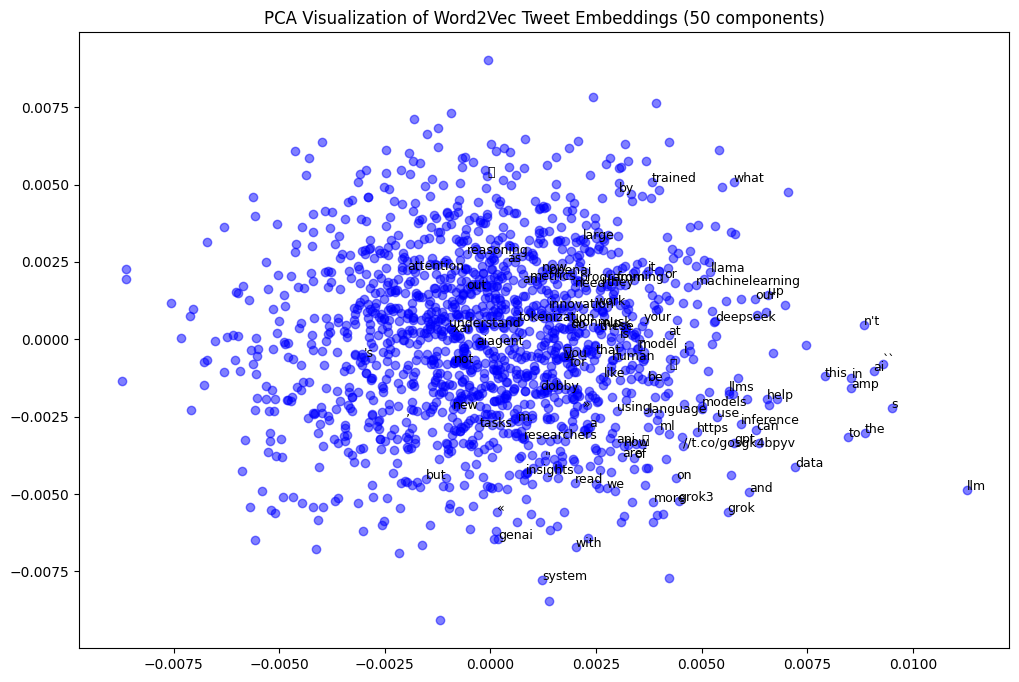

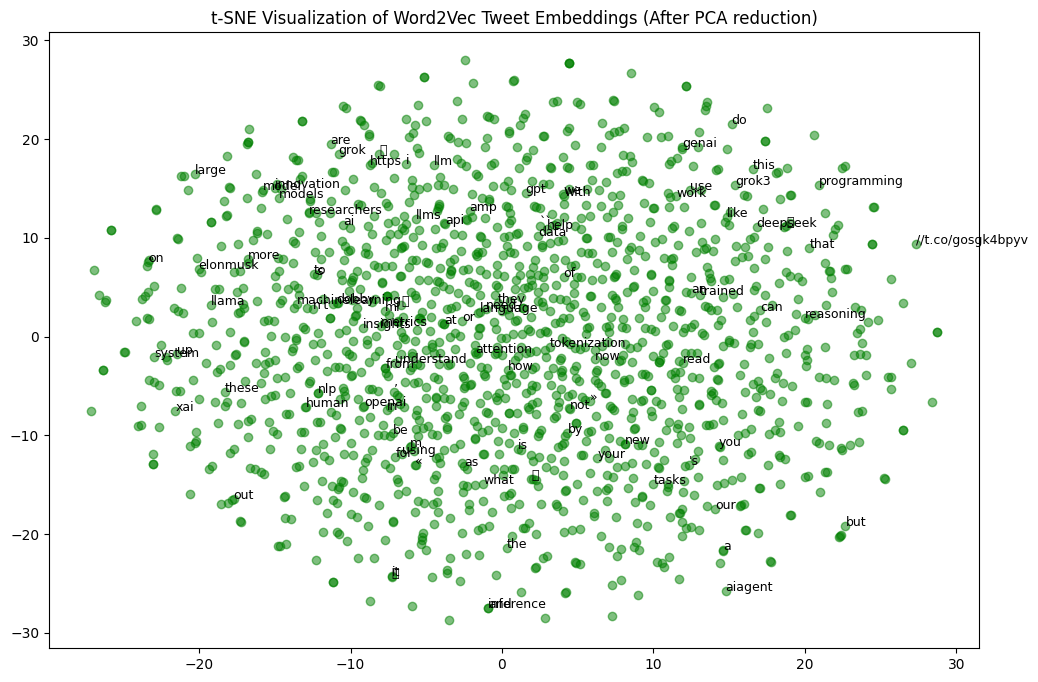

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim

# Load the trained Word2Vec model
model = gensim.models.Word2Vec.load("word2vec_tweet_model_300d.model")

words = list(model.wv.index_to_key)  # List of words
word_vectors = np.array([model.wv[word] for word in words])

# Perform PCA to reduce from 300 to 50 dimensions
pca = PCA(n_components=50)
pca_result = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='blue')

for i, word in enumerate(words[:100]):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontsize=9)

plt.title('PCA Visualization of Word2Vec Tweet Embeddings (50 components)')
plt.show()

# Plotting t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5, color='green')

for i, word in enumerate(words[:100]):
    plt.annotate(word, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=9)

plt.title('t-SNE Visualization of Word2Vec Tweet Embeddings (After PCA reduction)')
plt.show()


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

word_pairs = [('king', 'queen'), ('man', 'woman'), ('dog', 'cat')]

def cosine_sim(word1, word2):
    if word1 in model.wv and word2 in model.wv:
        vec1 = model.wv[word1].reshape(1, -1)
        vec2 = model.wv[word2].reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    else:
        return None

# Calculate and print cosine similarity for selected pairs
for word1, word2 in word_pairs:
    similarity = cosine_sim(word1, word2)
    if similarity is not None:
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
    else:
        print(f"One or both words '{word1}' and '{word2}' are not in the vocabulary.")


One or both words 'king' and 'queen' are not in the vocabulary.
One or both words 'man' and 'woman' are not in the vocabulary.
One or both words 'dog' and 'cat' are not in the vocabulary.


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [ ]:
# 1. Sentiment Analysis
# 2. columns : document_id, clean_text, sentiment(positive, negative, or neutral)

In [ ]:
# The GitHub link of your final csv file


# Link: https://github.com/Gopi-1818/Gopikrishna_INFO5731_Spring2025/blob/main/labeled_tweets.csv



# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

The assignment is good and helped me know on which kind of data i can perform sentiment analysis. Some of the challenges are ensuring accurate sentiment labeling, especially for neutral or mixed-tone tweets. i really enjoyed working with real time data and using AI to assist with labeling. It look more time for me to debugging.I think time given will be quite enough.

